In [1]:
# Instalar Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Instalar la biblioteca 'datasets' de Hugging Face
!pip install datasets

# Instalar otras dependencias (si es necesario)
!pip install pyyaml==5.1 pycocotools>=2.0.1


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-arcb3ial
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-arcb3ial
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4e80df1e58901557e2824ce3b488d30209a9be33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6112425 sha256=28558536fd5a1751de380307556a

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
# Importar las bibliotecas necesarias
import os
import json
import numpy as np
from datasets import load_dataset
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from PIL import Image
import cv2
import matplotlib.pyplot as plt


In [3]:
import os
import json
from PIL import Image

# Función para convertir el dataset al formato COCO
def to_coco_format(data_set):
    coco_format = {
        "info": {
            "description": "Custom dataset",
            "url": "",
            "version": "1.0",
            "year": 2023,
            "contributor": "",
            "date_created": "2023-10-07"
        },
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": "placa", "supercategory": "none"}]
    }

    annotation_id = 0
    for key, split_data in data_set.items():
        for item in split_data:
            image = {
                "id": item['image_id'],
                "width": item['width'],
                "height": item['height'],
                "file_name": str(item['image_id']) + ".jpg",
                "license": 0,
                "date_captured": ""
            }
            coco_format["images"].append(image)

            for obj_id, area, bbox, category in zip(item['objects']['id'],
                                                    item['objects']['area'],
                                                    item['objects']['bbox'],
                                                    item['objects']['category']):
                annotation = {
                    "id": annotation_id,
                    "image_id": item['image_id'],
                    "category_id": category,
                    "bbox": [bbox[0], bbox[1], bbox[2], bbox[3]],
                    "area": area,
                    "segmentation": [],
                    "iscrowd": 0,
                    "bbox_mode": BoxMode.XYWH_ABS  # Agregar bbox_mode aquí
                }
                coco_format["annotations"].append(annotation)
                annotation_id += 1

    return coco_format

# Función para guardar el dataset en formato COCO en un archivo JSON
def save_coco_json(coco_data, split):
    directory = f"/content/faster_rcnn/{split}/labels"
    os.makedirs(directory, exist_ok=True)

    with open(f"{directory}/annotations.json", "w") as f:
        json.dump(coco_data, f, indent=4)

def save_images(data_set):
    for split, items in data_set.items():
        directory = f"/content/faster_rcnn/{split}/images"
        os.makedirs(directory, exist_ok=True)

        for item in items:
            image_path = f"{directory}/{item['image_id']}.jpg"
            try:
                item['image'].save(image_path)
            except Exception as e:
                print(f"Error al guardar {image_path}. Error: {e}")





In [4]:
data_set = load_dataset("keremberke/license-plate-object-detection", name="full")


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [5]:
# Procesar y guardar el dataset
# Convertir a formato COCO
coco_data_train = to_coco_format({"train": data_set["train"]})
coco_data_validation = to_coco_format({"validation": data_set["validation"]})
coco_data_test = to_coco_format({"test": data_set["test"]})

# Guardar datos en formato COCO como archivos JSON
save_coco_json(coco_data_train, "train")
save_coco_json(coco_data_validation, "validation")
save_coco_json(coco_data_test, "test")

In [6]:
# Guardar imágenes
save_images(data_set)

In [19]:
# Importar las bibliotecas necesarias
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Importar algunas utilidades comunes
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import json

# Registrar el dataset en formato COCO
def load_data(d):
    data = json.load(open(f"/content/faster_rcnn/{d}/labels/annotations.json"))
    for img in data['images']:
        img['file_name'] = f"/content/faster_rcnn/{d}/images/{img['file_name']}"  # Añadir la ruta completa
        img_annotations = [a for a in data['annotations'] if a['image_id'] == img['id']]
        img['annotations'] = img_annotations
    return data['images']


# Registrar los datasets
for d in ["train", "validation", "test"]:
    DatasetCatalog.register(f"/content/faster_rcnn/{d}", lambda d=d: load_data(d))
    MetadataCatalog.get(f"/content/faster_rcnn/{d}").set(thing_classes=["placa"])




In [8]:
# Obtener los metadatos para el dataset de entrenamiento
placa_metadata = MetadataCatalog.get("/content/faster_rcnn/train")

In [9]:
placa_metadata

namespace(name='/content/faster_rcnn/train', thing_classes=['placa'])

In [28]:
# Configurar el modelo y los hiperparámetros
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# Usando rutas completas para la claridad
cfg.DATASETS.TRAIN = ("/content/faster_rcnn/train",)
cfg.DATASETS.TEST = ("/content/faster_rcnn/validation",)  # No usar "test" durante el entrenamiento

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Cargar pesos preentrenados

N = len(data_set["train"])  # Asegúrate de que 'data_set' está definido y disponible en este contexto
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.MAX_ITER = 2000
cfg.SOLVER.BASE_LR = 0.001
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Solo una clase: placa

# Entrenar el modelo
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Guardar el modelo entrenado
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Establecer el umbral para esta fase
cfg.DATASETS.TEST = ("/content/faster_rcnn/test",)
predictor = DefaultPredictor(cfg)


[10/14 09:46:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/14 09:46:36 d2.engine.train_loop]: Starting training from iteration 0
[10/14 09:46:58 d2.utils.events]:  eta: 0:34:55  iter: 19  total_loss: 0.9377  loss_cls: 0.7279  loss_box_reg: 0.1566  loss_rpn_cls: 0.0314  loss_rpn_loc: 0.009481    time: 1.0549  last_time: 1.0572  data_time: 0.0745  last_data_time: 0.0414   lr: 1.9981e-05  max_mem: 4868M
[10/14 09:47:17 d2.utils.events]:  eta: 0:31:49  iter: 39  total_loss: 0.7054  loss_cls: 0.4707  loss_box_reg: 0.1754  loss_rpn_cls: 0.02989  loss_rpn_loc: 0.007926    time: 0.9987  last_time: 0.8873  data_time: 0.0345  last_data_time: 0.0245   lr: 3.9961e-05  max_mem: 5129M
[10/14 09:47:35 d2.utils.events]:  eta: 0:30:59  iter: 59  total_loss: 0.4917  loss_cls: 0.2702  loss_box_reg: 0.1777  loss_rpn_cls: 0.02453  loss_rpn_loc: 0.00734    time: 0.9749  last_time: 0.9229  data_time: 0.0248  last_data_time: 0.0284   lr: 5.9941e-05  max_mem: 5129M
[10/14 09:47:55 d2.utils.events]:  eta: 0:30:48  iter: 79  total_loss: 0.4582  loss_cls: 0.2171  los

In [27]:
some_data = DatasetCatalog.get("/content/faster_rcnn/test")
print(some_data[0])  # Imprime la primera entrada para verificar su estructura.

{'width': 472, 'height': 303, 'file_name': '/content/faster_rcnn/test/images/754.jpg', 'license': 0, 'date_captured': '', 'annotations': [{'id': 0, 'image_id': 754, 'category_id': 0, 'bbox': [230.0, 70.0, 79.0, 73.0], 'area': 5767, 'segmentation': [], 'iscrowd': 0, 'bbox_mode': 1}], 'image_id': 754}


In [17]:
for d in ["train", "validation", "test"]:
    DatasetCatalog.remove(f"/content/faster_rcnn/{d}")

In [22]:
# Registrar el dataset en formato COCO
def load_data(d):
    data = json.load(open(f"/content/faster_rcnn/{d}/labels/annotations.json"))
    for img in data['images']:
        img['file_name'] = f"/content/faster_rcnn/{d}/images/{img['file_name']}"  # Añadir la ruta completa
        img_annotations = [a for a in data['annotations'] if a['image_id'] == img['id']]
        img['annotations'] = img_annotations
        img['image_id'] = img.pop('id')  # Cambiar 'id' a 'image_id'
    return data['images']

for d in ["train", "validation", "test"]:
    DatasetCatalog.remove(f"/content/faster_rcnn/{d}")

for d in ["train", "validation", "test"]:
    DatasetCatalog.register(f"/content/faster_rcnn/{d}", lambda d=d: load_data(d))
    MetadataCatalog.get(f"/content/faster_rcnn/{d}").set(thing_classes=["placa"])




In [26]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))  # Ajusta esto según tu archivo de configuración.
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Ajusta el umbral según tus necesidades.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Tienes una sola clase: "placa"

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("/content/faster_rcnn/validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "/content/faster_rcnn/validation")
inference_results = inference_on_dataset(predictor.model, val_loader, evaluator)
print(inference_results)

WARNING [10/14 08:52:52 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/14 08:52:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/14 08:52:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/14 08:52:53 d2.data.common]: Serializing 1765 elements to byte tensors and concatenating them all ...
[10/14 08:52:53 d2.data.common]: Serialized dataset takes 0.52 MiB
[10/14 08:52:53 d2.evaluation.evaluator]: Start inference on 1765 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[10/14 08:52:55 d2.evaluation.evaluator]: Inference done 11/1765. Dataloading: 0.0047 s/iter. Inference: 0.1029 s/iter. Eval: 0.0003 s/iter. Total: 0.1079 s/iter. ETA=0:03:09
[10/14 08:53:00 d2.evaluation.evaluator]: Inference done 59/1765. Dataloading: 0.0023 s/iter. Inference: 0.1031 s/iter. Eval: 0.0003 s/iter. Total: 0.1058 s/iter. ETA=0:03:00
[10/14 08:53:05 d2.evaluation.evaluator]: Inference done 106/1765. Dataloading: 0.0026 s/iter. Inference: 0.1037 s/iter. Eval: 0.0003 s/iter. Total: 0.1066 s/iter. ETA=0:02:56
[10/14 08:53:10 d2.evaluation.evaluator]: Inference done 151/1765. Dataloading: 0.0037 s/iter. Inference: 0.1043 s/iter. Eval: 0.0003 s/iter. Total: 0.1083 s/iter. ETA=0:02:54
[10/14 08:53:15 d2.evaluation.evaluator]: Inference done 199/1765. Dataloading: 0.0033 s/iter. Inference: 0.1042 s/iter. Eval: 0.0003 s/iter. Total: 0.1078 s/iter. ETA=0:02:48
[10/14 08:53:20 d2.evaluation.evaluator]: Inference done 244/1765. Dataloading: 0.0037 s/iter. Inference: 0.1044 s/iter. E

In [11]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))  # Asegúrate de usar la misma base de configuración que usaste durante el entrenamiento.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Configura el umbral de confianza para la inferencia
cfg.MODEL.WEIGHTS = "/content/output/model_final.pth"  # Ruta a tu modelo entrenado
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # XXX es el número de clases que entrenaste
predictor = DefaultPredictor(cfg)



evaluator = COCOEvaluator("/content/faster_rcnn/validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "/content/faster_rcnn/validation")
print(inference_on_dataset(predictor.model, val_loader, evaluator))



[10/14 08:05:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output/model_final.pth ...
WARNING [10/14 08:05:06 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[10/14 08:05:06 d2.evaluation.coco_evaluation]: Trying to convert '/content/faster_rcnn/validation' to COCO format ...
[10/14 08:05:06 d2.data.datasets.coco]: Converting annotations of dataset '/content/faster_rcnn/validation' to COCO format ...)
[10/14 08:05:06 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/14 08:05:06 d2.data.datasets.coco]: Conversion finished, #images: 1765, #annotations: 1840
[10/14 08:05:06 d2.data.datasets.coco]: Caching COCO format annotations at '/content/faster_rcnn/validation_coco_format.json' ...
[10/14 08:05:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyError: ignored

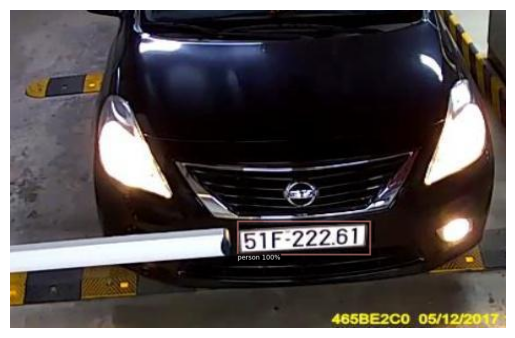

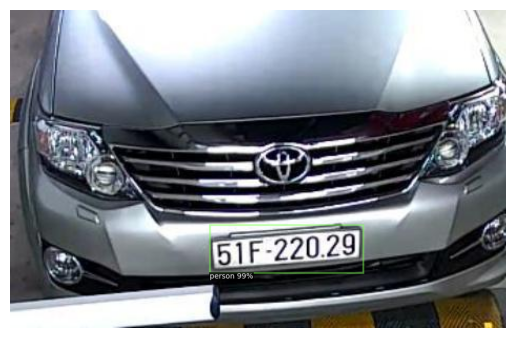

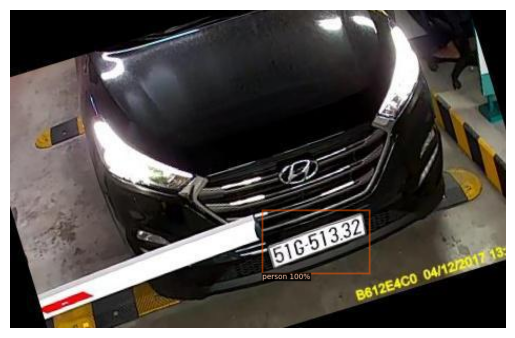

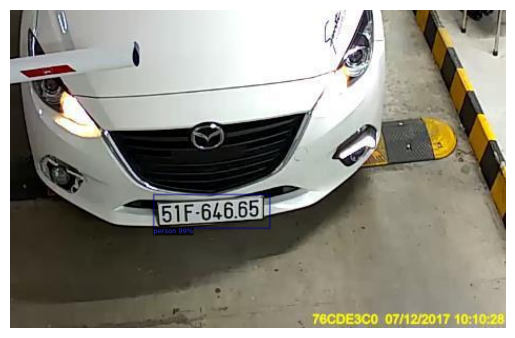

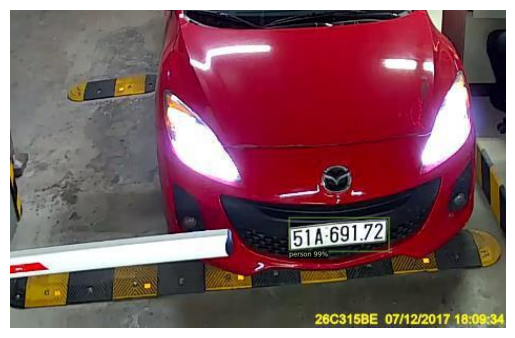

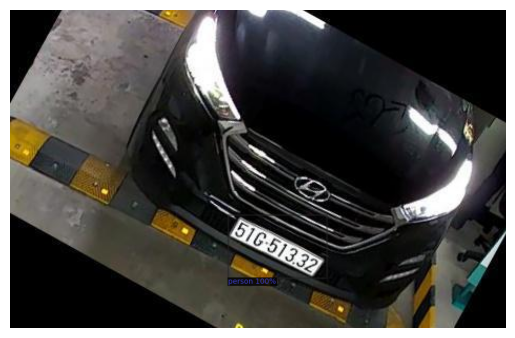

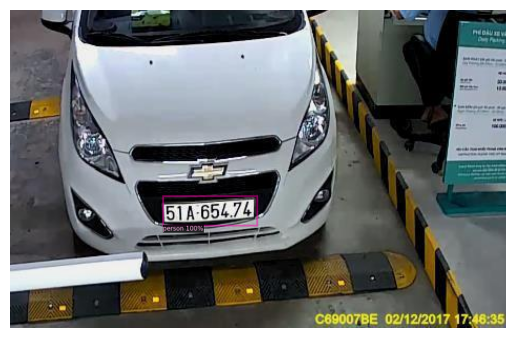

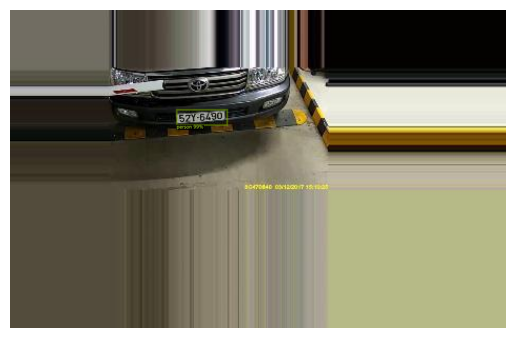

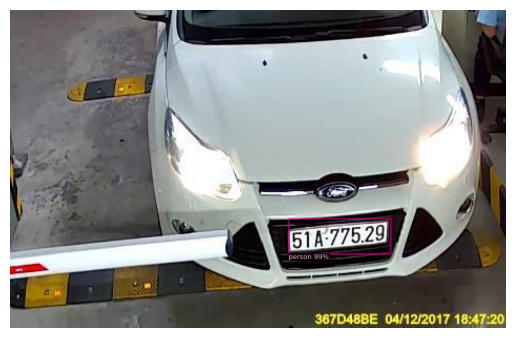

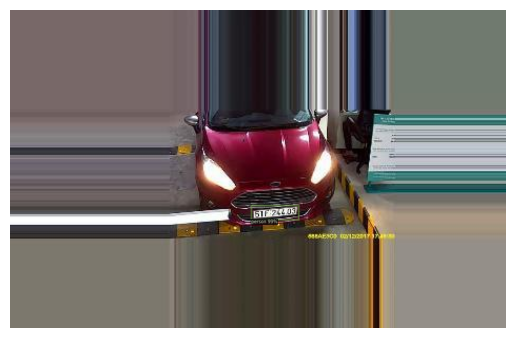

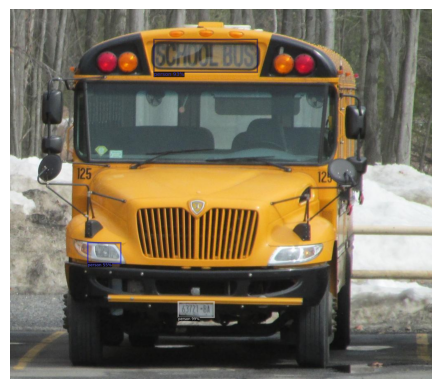

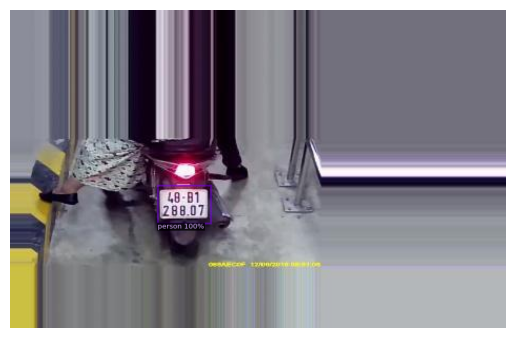

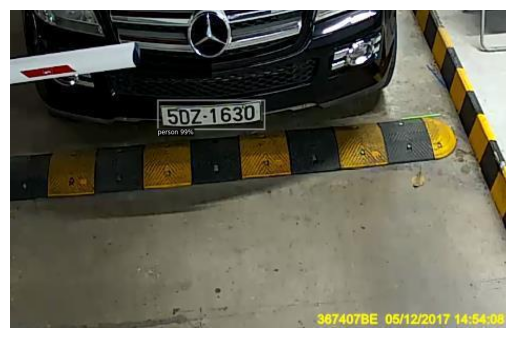

KeyboardInterrupt: ignored

In [16]:
def visualize_predictions(img, outputs):
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=2.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_image = v.get_image()[:, :, ::-1]
    plt.imshow(result_image)
    plt.axis('off')  # oculta los ejes para una mejor visualización
    plt.show()

image_folder = "/content/faster_rcnn/test/images"
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and (f.endswith('.jpg') or f.endswith('.png'))]


for image_file in image_files:
    img_path = os.path.join(image_folder, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Realiza la predicción con el predictor
    outputs = predictor(img)

    # Visualiza la predicción
    visualize_predictions(img, outputs)


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog

# Configura el predictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

image_folder = "/content/faster_rcnn/images_prueba"
for image_name in os.listdir(image_folder):
    if image_name.endswith(".jpg") or image_name.endswith(".png"):
        image_path = os.path.join(image_folder, image_name)
        im = cv2.imread(image_path)

        # Obtén las predicciones
        outputs = predictor(im)
        instances = outputs["instances"].to("cpu")

        # Dibuja los bounding boxes y anotaciones
        for box, score, class_idx in zip(instances.pred_boxes, instances.scores, instances.pred_classes):
            x1, y1, x2, y2 = [int(val) for val in box]
            label = f"{MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[class_idx]}: {score:.2f}"

            # Dibuja el bounding box con un grosor mayor
            cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 4)

            # Dibuja el texto con un tamaño de fuente mayor y grosor mayor
            cv2.putText(im, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Muestra la imagen con bounding boxes y anotaciones
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.show()


Output hidden; open in https://colab.research.google.com to view.